In [172]:
import os, pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [173]:
def data_pipe(
            data_path = 'data/Fault_Prediction.xlsx',
            class_dict = {
                        "Solar Panel": 0,
                        "Charge Controller": 1,
                        "Inverter": 2,
                        "Battery": 3
                    }):
    df = pd.read_excel(data_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['component_type'] = df['component_type'].apply(lambda x: class_dict[x])
    df = df.sort_values(by='DateTime')
    del df['DateTime'], \
        df['fault_status']
    df = df.dropna()
    
    X = df.drop(['predicted_time_to_fault (days)'], axis=1)
    Y = df['predicted_time_to_fault (days)']
    return X, Y

In [174]:
X, Y = data_pipe()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (921, 7)
Ytrain shape: (921,)
Xtest shape: (231, 7)
Ytest shape: (231,)


In [175]:
xgb = XGBRegressor(
                    n_estimators=15,
                    max_depth=10
                    )
xgb.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=15, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [176]:
with open('artifacts/fault_detection.pickle', 'wb') as f:
    pickle.dump(xgb, f)

In [177]:
Ptrain = xgb.predict(Xtrain)
Ptest = xgb.predict(Xtest)

Evaluates the performance of the trained model on the test set using three commonly used regression metrics

In [178]:
mse = mean_squared_error(Ytest, Ptest)
mae = mean_absolute_error(Ytest, Ptest)
r2 = r2_score(Ytest, Ptest)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 1.9649700907784806
Mean Absolute Error: 1.0065701923504782
R2 Score: 0.9037361610503342


### Vizualization of the Accuracy

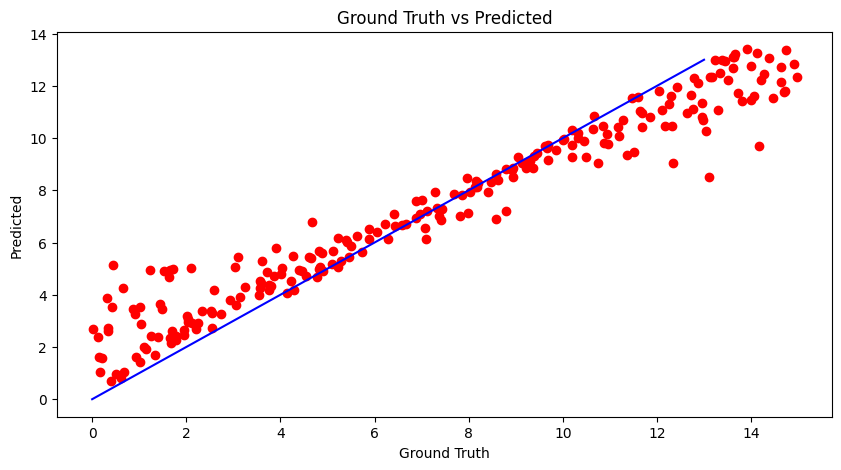

In [179]:
plt.figure(figsize=(10, 5))
plt.scatter(Ytest, Ptest, color='red')
plt.plot([0, 13], [0, 13], color='blue')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Ground Truth vs Predicted')
plt.show()

Calculates context-aware weights for each data point in the dataset based on the feature values, their deviations from expected ranges, and prediction errors

In [180]:
def calculate_context_weights(X, Y, P):
    """Calculate context-aware weights based on feature values and their ranges"""
    weights = np.ones(len(X))
    
    # Feature ranges
    feature_ranges = {
        'ambient_temperature (°C)': [20, 40],
        'irradiance (W/m²)': [400, 1000],
        'humidity (%)': [50, 90],
        'device_temperature (°C)': [25, 60],
        'output_current (A)': [5, 30],
        'output_voltage (V)': [12, 48]
    }
    
    # Context multipliers
    context_multipliers = {
        'temperature_stress': 1.5,
        'electrical_stress': 1.8,
        'environmental_stress': 1.3
    }
    
    # Convert Y and P to numpy arrays if they aren't already
    Y = np.array(Y)
    P = np.array(P)
    
    for i, (_, row) in enumerate(X.iterrows()):
        weight_multiplier = 1.0
        
        # Temperature stress
        temp_dev = abs(row['device_temperature (°C)'] - np.mean([25, 60]))
        if temp_dev > 15:
            weight_multiplier *= context_multipliers['temperature_stress']
        
        # Electrical stress
        current_stress = (row['output_current (A)'] - 5) / 25
        voltage_stress = (row['output_voltage (V)'] - 12) / 36
        if current_stress > 0.8 or voltage_stress > 0.8:
            weight_multiplier *= context_multipliers['electrical_stress']
        
        # Environmental stress
        if (row['humidity (%)'] < 60 or row['humidity (%)'] > 80 or 
            row['irradiance (W/m²)'] > 800):
            weight_multiplier *= context_multipliers['environmental_stress']
        
        # Component-specific weights
        component_weights = {0: 1.2, 1: 1.1, 2: 1.3, 3: 1.4}
        weight_multiplier *= component_weights[row['component_type']]
        
        # Prediction error weight
        error = abs(Y[i] - P[i])
        weight_multiplier *= (1 + error / Y[i] if Y[i] != 0 else 1)
        
        weights[i] = weight_multiplier
    
    return weights

calculates the context-aware weighted metrics by applying the weights derived from the calculate_context_weights function to the test dataset. The weighted metrics (Mean Squared Error, Mean Absolute Error, and R² Score) are computed using the sample_weight parameter in the respective evaluation functions.

In [181]:
# Calculate context-aware weights
train_weights = calculate_context_weights(Xtrain, Ytrain, Ptrain)
test_weights = calculate_context_weights(Xtest, Ytest, Ptest)

# Calculate weighted metrics
weighted_mse = mean_squared_error(Ytest, Ptest, sample_weight=test_weights)
weighted_mae = mean_absolute_error(Ytest, Ptest, sample_weight=test_weights)
weighted_r2 = r2_score(Ytest, Ptest, sample_weight=test_weights)

print("\nContext-Aware Weighted Metrics:")
print(f"Weighted Mean Squared Error: {weighted_mse}")
print(f"Weighted Mean Absolute Error: {weighted_mae}")
print(f"Weighted R2 Score: {weighted_r2}")


Context-Aware Weighted Metrics:
Weighted Mean Squared Error: 4.592932486755881
Weighted Mean Absolute Error: 1.8158306104340525
Weighted R2 Score: 0.7895470297018841


### Vizualization of Orginal vs weighted predictions

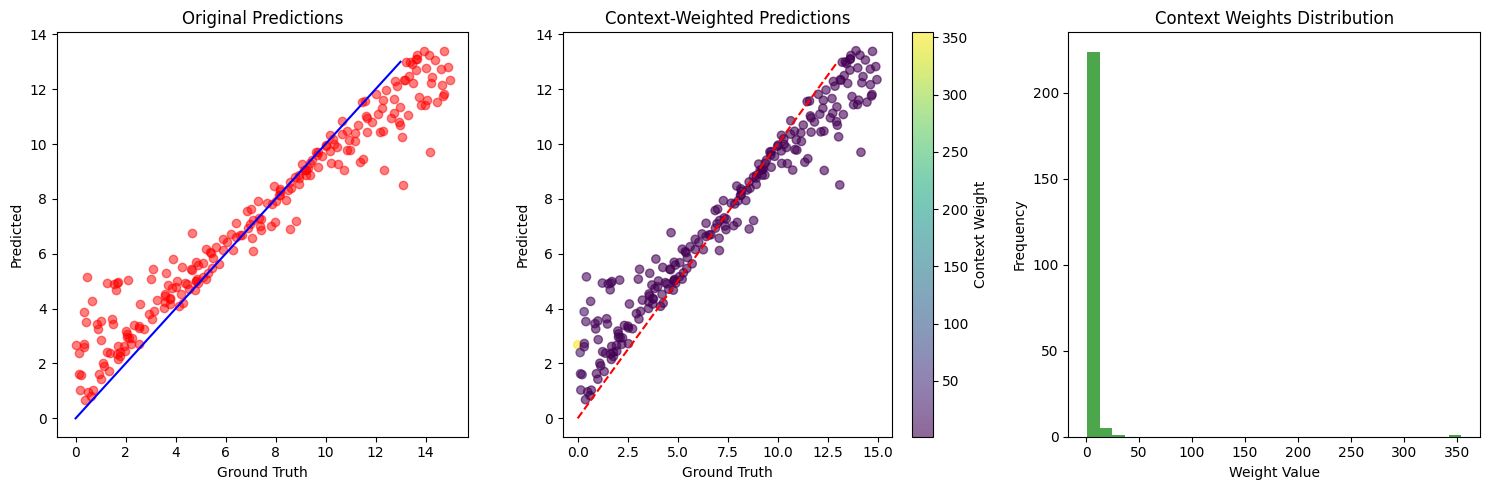

In [182]:
# Visualization of results
plt.figure(figsize=(15, 5))

# Original predictions plot
plt.subplot(131)
plt.scatter(Ytest, Ptest, color='red', alpha=0.5)
plt.plot([0, 13], [0, 13], color='blue')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Original Predictions')

# Weighted predictions plot
plt.subplot(132)
plt.scatter(Ytest, Ptest, c=test_weights, cmap='viridis', alpha=0.6)
plt.colorbar(label='Context Weight')
plt.plot([0, 13], [0, 13], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('Context-Weighted Predictions')

# Weight distribution plot
plt.subplot(133)
plt.hist(test_weights, bins=30, color='green', alpha=0.7)
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Context Weights Distribution')

plt.tight_layout()
plt.show()

### Save the artifact

In [183]:
with open('artifacts/fault_detection.pickle', 'rb') as f:
    xgb = pickle.load(f)

Determines the dominant context affecting a given solar component based on the feature values in the dataframe df and its corresponding context weight. It checks if certain conditions (like temperature stress, electrical stress, or environmental stress) are met and returns the dominant context based on the highest weight.

In [184]:
def get_dominant_context(df, weight):
    
    contexts = {
        'temperature_stress': {
            'weight': 1.5,
            'condition': abs(df['device_temperature (°C)'].iloc[0] - np.mean([25, 60])) > 15
        },
        'electrical_stress': {
            'weight': 1.8,
            'condition': (df['output_current (A)'].iloc[0] - 5) / 25 > 0.8 or 
                        (df['output_voltage (V)'].iloc[0] - 12) / 36 > 0.8
        },
        'environmental_stress': {
            'weight': 1.3,
            'condition': (df['humidity (%)'].iloc[0] < 60 or 
                         df['humidity (%)'].iloc[0] > 80 or 
                         df['irradiance (W/m²)'].iloc[0] > 800)
        }
    }
    
    active_contexts = []
    for context_name, context_info in contexts.items():
        if context_info['condition']:
            active_contexts.append((context_name, context_info['weight']))
    
    if not active_contexts:
        return "Normal operating conditions"
    
    return max(active_contexts, key=lambda x: x[1])[0].replace('_', ' ').title()

Takes JSON input data, processes it through the trained model, and calculates the predicted time to fault for a given component. It adjusts the predicted time by applying context-aware weights, and determines the dominant stress factor affecting the component.

In [185]:
def inference_fault(
                    json_data,
                    class_dict = {
                                "Solar Panel": 0,
                                "Charge Controller": 1,
                                "Inverter": 2,
                                "Battery": 3
                                }
                    ):
    df = pd.DataFrame([json_data])
    df['component_type'] = df['component_type'].apply(lambda x: class_dict[x])
    
    single_weight = calculate_context_weights(
        df, 
        pd.Series([0]),
        np.array([0])
    )[0]
    
    time_to_fault = xgb.predict(df)[0]
    adjusted_time = time_to_fault * (1 / single_weight)
    adjusted_time = adjusted_time + 1 if adjusted_time - int(adjusted_time) > 0.5 else int(adjusted_time)
    
    current_time = datetime.now()
    fault_time = current_time + timedelta(days=adjusted_time)
    fault_date = fault_time.strftime("%d-%m-%Y")
    
    dominant_context = get_dominant_context(df, single_weight)
    
    return {
        'component': json_data['component_type'],
        'days_to_fault': int(adjusted_time),
        'fault_date': fault_date,
        'context': dominant_context,
        'weight': single_weight
    }

Takes a set of component data, processes each component's data through the inference_fault function, and generates detailed predictions for fault timing and context.

In [186]:
def analyze_all_components(sample_jsons):
    
    predictions = []
    
    print("\nDETAILED FAULT PREDICTION SUMMARY\n")
    print("=" * 40)
    
    # Get predictions for all components
    for component, data in sample_jsons.items():
        pred = inference_fault(data)
        predictions.append(pred)
    
    # Sort components by urgency
    sorted_pred = sorted(predictions, key=lambda x: x['days_to_fault'])
    
    # Print individual component predictions
    print("Component-wise Fault Predictions:\n")
    for i, pred in enumerate(sorted_pred, 1):
        print(f"{i}. {pred['component']}:")
        print(f"   • Time to Fault: {pred['days_to_fault']} days")
        print(f"   • Predicted Fault Date: {pred['fault_date']}")
        print(f"   • Context: {pred['context']}")
        print(f"   • Risk Weight: {pred['weight']:.2f}\n")
    
    # Critical alert for earliest fault
    earliest_fault = sorted_pred[0]  # First component in sorted list
    print("=" * 40)
    print("CRITICAL ALERT:")
    print(f"The {earliest_fault['component']} requires immediate attention as it is predicted to fail first:")
    print(f"• Expected failure in {earliest_fault['days_to_fault']} days")
    print(f"• Predicted fault date: {earliest_fault['fault_date']}")
    print(f"• Failure context: {earliest_fault['context']}")
    print(f"• Risk weight: {earliest_fault['weight']:.2f}")
    print("=" * 40)
    
    # Add visualization
    visualize_fault_predictions(predictions)
    
    return predictions

### visualizations for fault predictions

In [187]:
def visualize_fault_predictions(predictions):
    
    # Extract data for plotting
    components = [p['component'] for p in predictions]
    days_to_fault = [p['days_to_fault'] for p in predictions]
    weights = [p['weight'] for p in predictions]
    contexts = [p['context'] for p in predictions]
    
    # Create a figure with multiple subplots
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    # Timeline Plot
    ax1 = plt.subplot(231)
    colors = ['red' if d == min(days_to_fault) else 'royalblue' for d in days_to_fault]
    bars = ax1.barh(components, days_to_fault, color=colors, alpha=0.7)
    ax1.set_title('Days Until Predicted Fault by Component', pad=15, fontsize=12)
    ax1.set_xlabel('Days to Fault')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2,
                f'{int(width)} days', 
                ha='left', va='center', fontweight='bold')
    
    # Context Weight Distribution
    ax2 = plt.subplot(232)
    scatter = ax2.scatter(days_to_fault, weights, c=range(len(components)), 
                         cmap='viridis', s=200)
    for i, comp in enumerate(components):
        ax2.annotate(comp, (days_to_fault[i], weights[i]), 
                    xytext=(5, 5), textcoords='offset points')
    ax2.set_xlabel('Days to Fault')
    ax2.set_ylabel('Context Weight')
    ax2.set_title('Fault Prediction vs Context Weight', pad=15, fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Component Health Gauge Chart
    ax3 = plt.subplot(233, projection='polar')
    max_days = max(days_to_fault)
    angles = np.linspace(0, 2*np.pi, len(components), endpoint=False)
    health_scores = [(d/max_days) * 100 for d in days_to_fault]
    
    ax3.plot(angles, health_scores, 'o-')
    ax3.fill(angles, health_scores, alpha=0.25)
    ax3.set_xticks(angles)
    ax3.set_xticklabels(components)
    ax3.set_title('Component Health Score', pad=15, fontsize=12)
    
    # Context Distribution
    ax4 = plt.subplot(234)
    context_counts = pd.Series(contexts).value_counts()
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(context_counts)))
    ax4.pie(context_counts.values, labels=context_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax4.set_title('Distribution of Fault Contexts', pad=15, fontsize=12)
    
    # Component Risk Matrix
    ax5 = plt.subplot(235)
    urgency = [1/d for d in days_to_fault]  # Convert days to urgency
    scatter = ax5.scatter(weights, urgency, c=range(len(components)), 
                         cmap='RdYlGn_r', s=200)
    
    for i, comp in enumerate(components):
        ax5.annotate(comp, (weights[i], urgency[i]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax5.set_xlabel('Context Weight')
    ax5.set_ylabel('Urgency (1/Days)')
    ax5.set_title('Component Risk Matrix', pad=15, fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # Critical Component Focus
    ax6 = plt.subplot(236)
    critical_idx = days_to_fault.index(min(days_to_fault))
    critical_component = components[critical_idx]
    
    data = {
        'Days to Fault': days_to_fault[critical_idx],
        'Context Weight': weights[critical_idx],
        'Health Score': health_scores[critical_idx]
    }
    
    colors = ['crimson', 'orange', 'forestgreen']
    bars = ax6.bar(data.keys(), data.values(), color=colors, alpha=0.7)
    ax6.set_title(f'Critical Component: {critical_component}', pad=15, fontsize=12)
    ax6.set_ylim(0, max(data.values()) * 1.2)
    ax6.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.1f}', ha='center', va='bottom')
    
    # Add main title
    fig.suptitle('Comprehensive Fault Prediction Analysis\n', fontsize=16, y=0.95)
    
    plt.tight_layout()
    plt.show()
    
    # # Print textual summary
    # print("\nDETAILED FAULT PREDICTION SUMMARY")
    # print("=" * 40)
    
    # # Sort components by urgency
    # sorted_pred = sorted(predictions, key=lambda x: x['days_to_fault'])
    
    # for i, pred in enumerate(sorted_pred, 1):
    #     print(f"\n{i}. {pred['component']}:")
    #     print(f"   • Time to Fault: {pred['days_to_fault']} days")
    #     print(f"   • Predicted Fault Date: {pred['fault_date']}")
    #     print(f"   • Context: {pred['context']}")
    #     print(f"   • Risk Weight: {pred['weight']:.2f}")

### Sample data input

In [188]:
sample_jsons = {
    "Solar Panel": {
            "ambient_temperature (°C)" : 28.5,
            "irradiance (W/m²)" : 850.02,
            "humidity (%)" : 65.88,
            "device_temperature (°C)" : 52.69,
            "output_current (A)" : 25.01,
            "output_voltage (V)" : 42.45,
            "component_type" : "Solar Panel"
    },
    "Charge Controller": {
            "ambient_temperature (°C)" : 27.49,
            "irradiance (W/m²)" : 557.02,
            "humidity (%)" : 72.88,
            "device_temperature (°C)" : 47.69,
            "output_current (A)" : 23.01,
            "output_voltage (V)" : 25.45,
            "component_type" : "Charge Controller"
    },
    "Inverter": {
            "ambient_temperature (°C)" : 32.45,
            "irradiance (W/m²)" : 650.75,
            "humidity (%)" : 78.92,
            "device_temperature (°C)" : 55.34,
            "output_current (A)" : 28.67,
            "output_voltage (V)" : 35.89,
            "component_type" : "Inverter"
    },
    "Battery": {
            "ambient_temperature (°C)" : 29.78,
            "irradiance (W/m²)" : 600.23,
            "humidity (%)" : 68.45,
            "device_temperature (°C)" : 43.21,
            "output_current (A)" : 19.87,
            "output_voltage (V)" : 22.34,
            "component_type" : "Battery"
    }
}

In [189]:
# inference_fault(sample_json)


DETAILED FAULT PREDICTION SUMMARY

Component-wise Fault Predictions:

1. Solar Panel:
   • Time to Fault: 2 days
   • Predicted Fault Date: 07-12-2024
   • Context: Electrical Stress
   • Risk Weight: 2.81

2. Inverter:
   • Time to Fault: 2 days
   • Predicted Fault Date: 07-12-2024
   • Context: Electrical Stress
   • Risk Weight: 2.34

3. Charge Controller:
   • Time to Fault: 6 days
   • Predicted Fault Date: 11-12-2024
   • Context: Normal operating conditions
   • Risk Weight: 1.10

4. Battery:
   • Time to Fault: 6 days
   • Predicted Fault Date: 11-12-2024
   • Context: Normal operating conditions
   • Risk Weight: 1.40

CRITICAL ALERT:
The Solar Panel requires immediate attention as it is predicted to fail first:
• Expected failure in 2 days
• Predicted fault date: 07-12-2024
• Failure context: Electrical Stress
• Risk weight: 2.81


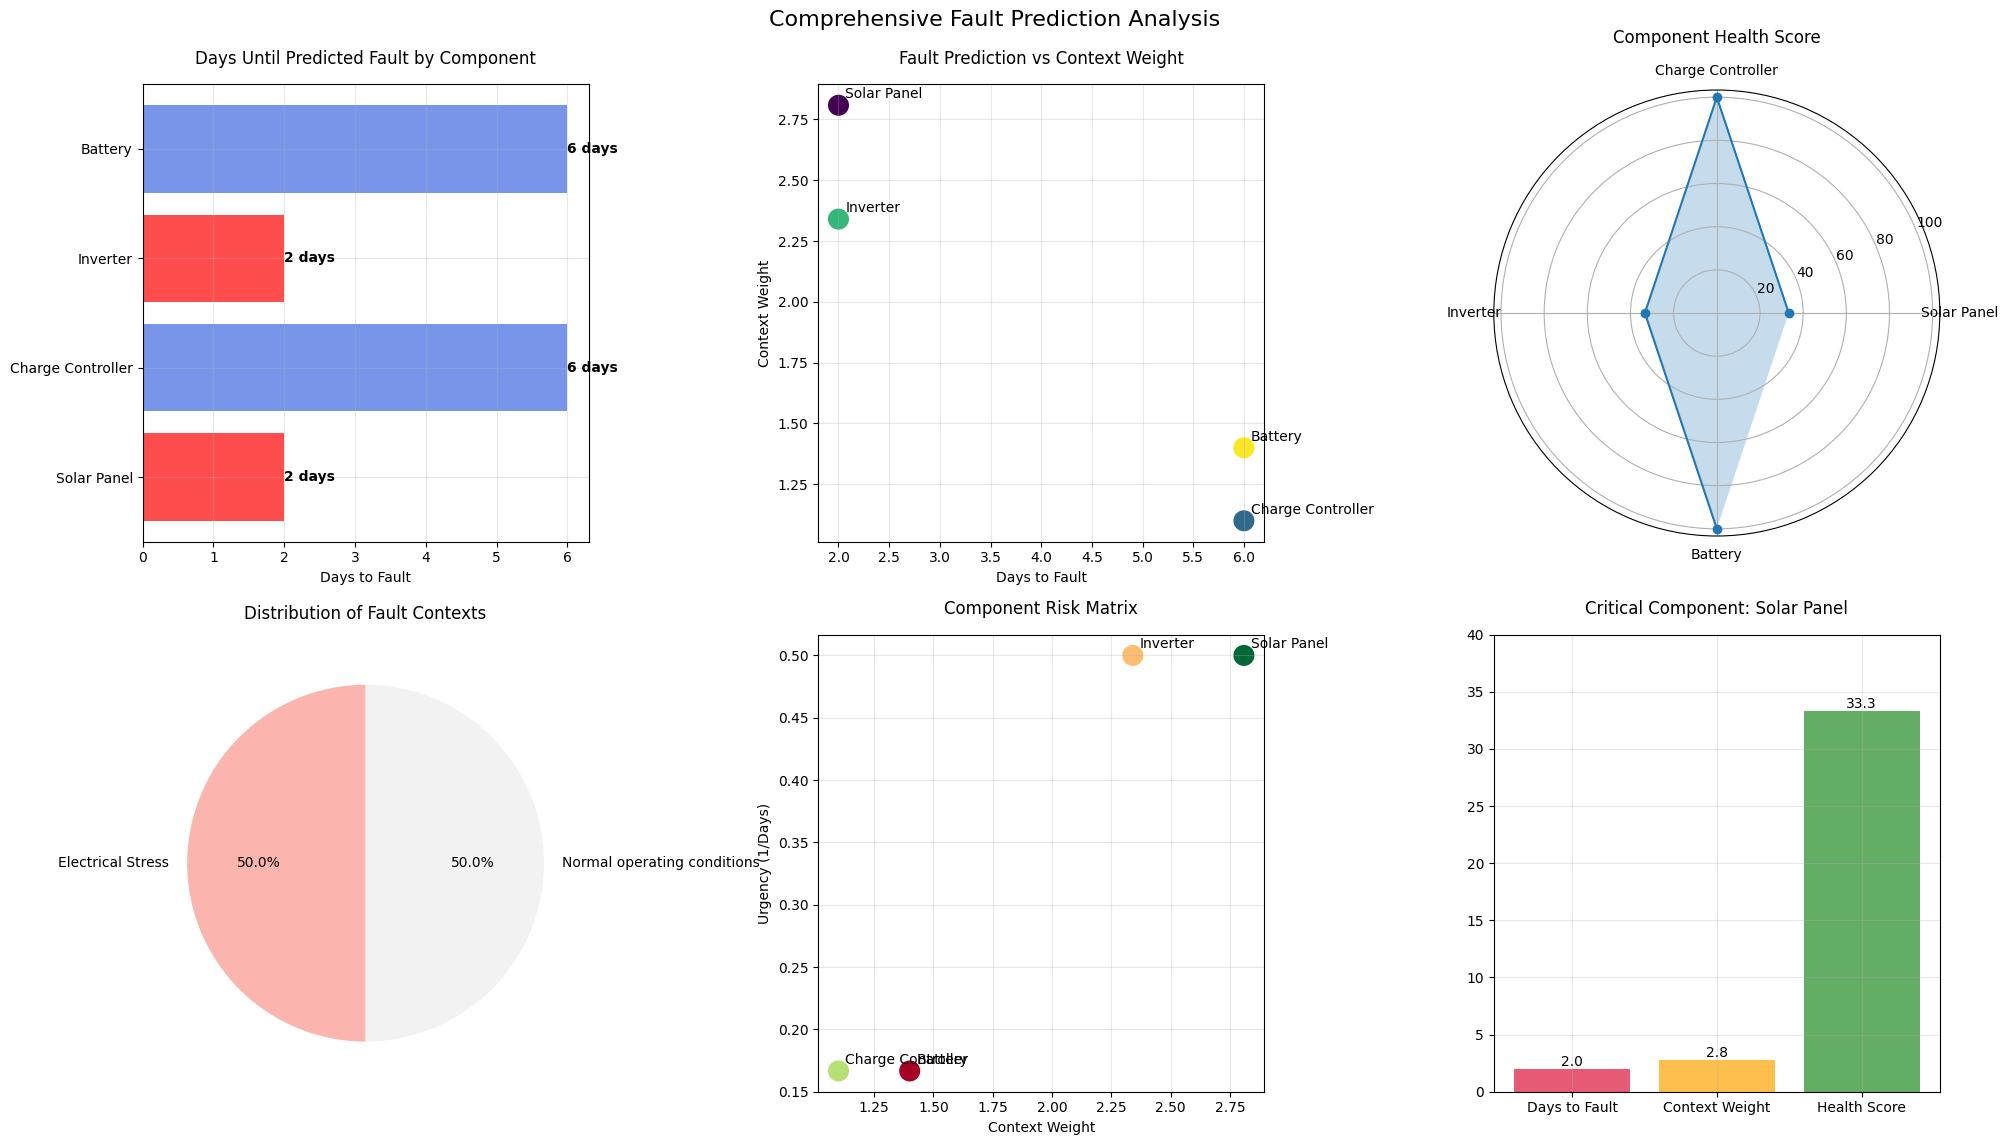

In [190]:
predictions = analyze_all_components(sample_jsons)